# Projeto #2 - Classificador supervisionado

Antes de começar, leia as [Instruções](https://github.com/thvmm/pos-ds-ia/tree/master/projeto_2#instru%C3%A7%C3%B5es) e os [Critérios de Avaliação](https://github.com/thvmm/pos-ds-ia/tree/master/projeto_2#crit%C3%A9rios-de-avalia%C3%A7%C3%A3o)


### 1) Qual a base escolhida?

Reuters Corpus Volume I, pois meu interesse maior nesse momento é análise de texto (revisão de literatura).
Infelizmente, primeiro por enrolação (deixei para o Carnaval...), e depois por necessidade (problemas de saúde), não houve tempo suficiente para rodar com a base grande... Além de várias dificuldades com matriz esparsa...
Dessa forma, na reta final optei, assumindo os riscos, a rodar com o titanic para agilizar o processo, e ao menos passar por todas as etapas do projeto.
Deixei o código inicial da tentativa de rodar a matriz esparsa, e complementei com os resultados do titanic. 
Como ganhamos um final de semana, depois de tudo pronto com o Titanic, mas resultados "decorados", resolvi pegar um dataframe com dados do COVID19 no Kaggle e explorar...

### 2) **(10%)** Pré-processamento: entendimento do conjunto de dados


In [927]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
# Algoritmos
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, Lasso, LinearRegression, Ridge, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
# Cross validation
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, mean_squared_error

from IPython.display import SVG, Image, display
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn import tree

In [928]:
# Carregando a base: rodou a primeira vez, e salvei cada conjunto em um arquivo específico para futuros acessos
#from sklearn.datasets import fetch_rcv1
#rcv1 = fetch_rcv1()

# Salvando os dados
from scipy import sparse
#sparse.save_npz("data.npz", rcv1.data)
#sparse.save_npz("target.npz", rcv1.target)
import numpy as np
#np.savetxt("sample_id.npy", rcv1.sample_id)
#np.savetxt("target_names.npy", rcv1.target_names, fmt="%s")

# Carregando a base a partir dos arquivos salvos na primeira rodada
#data = sparse.load_npz("data.npz")
#target = sparse.load_npz("target.npz")
#sample_id = np.loadtxt("sample_id.npy")
#target_names = np.loadtxt("target_names.npy", dtype="O")

# carregando a base do COVID
df = pd.read_csv("COVID19_open_line_list.csv")
df = df[['age', 'sex', 'city', 'province', 'country', 'wuhan(0)_not_wuhan(1)', 'latitude', 'longitude', 'geo_resolution', 'date_onset_symptoms', 'date_admission_hospital', 'date_confirmation', 'symptoms', 'lives_in_Wuhan', 'travel_history_dates', 'travel_history_location', 'reported_market_exposure', 'source', 'outcome', 'date_death_or_discharge', 'notes_for_discussion', 'location', 'country_new']]

# preparando a coluna target
df['death'] = 0
for index, row in df.iterrows():
    if (row['date_death_or_discharge'] != '') & (row['outcome'] in ('death', 'died')):
        df.loc[index, 'death'] = 1

# eliminando as colunas que deram origem à target
data_covid = df.drop(['death', 'date_death_or_discharge', 'outcome'], axis=1)
target_covid = df[['death']]
print('data_covid', data_covid.shape)
print('target_covid', target_covid.shape)

data_covid (14126, 21)
target_covid (14126, 1)


In [929]:
# Quais são minhas features?
# Difícil listar, são 47.236...
#print('Reuters', data.shape)

# COVID
print('data_covid', data_covid.columns.values)


data_covid ['age' 'sex' 'city' 'province' 'country' 'wuhan(0)_not_wuhan(1)'
 'latitude' 'longitude' 'geo_resolution' 'date_onset_symptoms'
 'date_admission_hospital' 'date_confirmation' 'symptoms' 'lives_in_Wuhan'
 'travel_history_dates' 'travel_history_location'
 'reported_market_exposure' 'source' 'notes_for_discussion' 'location'
 'country_new']


In [930]:
# Quais são minhas classes?
# São 103 classes, que representam os tópicos aos quais os textos podem estar relacionados.
# Elas são divididas em 4 grandes categorias: Corporate (CCAT), Economics (ECAT), Government (GCAT) e Markets (MCAT)
#target_names

In [931]:
# Como estão distribuidas minhas classes?
# Cada texto está vinculado a pelo menos um tópico, e até a 17 tópicos. Existem 5 ocorrências da classe 'GMIL', variando até 381.327 para a classe 'CCAT' (CCAT é a mais frequente).

#r = np.zeros(103, dtype=int)
#for i in range(target.shape[0]): # trocar para target.shape[0] para rodar com todos
#    r = r + target[i].toarray()
#pd.DataFrame(r[0], index=target_names).loc[['CCAT', 'ECAT', 'GCAT', 'MCAT']].plot.bar()


In [932]:
# Checagem se os valores estão dentro de um limite permitido ou razoável.

# Presume-se que sim. Os dados foram pré processados, o número de features é muito grande para testes, e não há parâmetros de referência para eventual avaliação.

In [933]:
# Tratamento de valores ausentes por eliminação ou substituição.

# Presume-se que não existem, pois trata-se de matriz esparsa, que por definição armazena somente valores existentes. Os dados foram pré processados.

# COVID
# Nulos
total = data_covid.isnull().sum().sort_values(ascending=False)
percent_1 = data_covid.isnull().sum()/data_covid.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data_covid = pd.concat([total, percent_2], axis=1, keys=['Total', '%']).sort_values(['Total'], ascending=False)
missing_data_covid

,Total,%
reported_market_exposure,14091,99.8
notes_for_discussion,13939,98.7
symptoms,13633,96.5
travel_history_dates,13623,96.4
lives_in_Wuhan,13561,96.0
date_admission_hospital,13396,94.8
date_onset_symptoms,13380,94.7
travel_history_location,13368,94.6
location,13102,92.8
sex,12862,91.1


In [934]:
# COVID
# corrige nulos
data_covid = data_covid.fillna(-1)

In [935]:
# Conversão do tipo de dados.

# Presume-se que não há necessidade, pois trata-se de matriz esparsa, que por definição armazena somente valores existentes iguais a 1. Os dados foram pré processados.

# COVID
# normaliza conteúdos
colunas = [col_name for col_name in data_covid.columns if data_covid[col_name].dtype == "O"]
for coluna in colunas:
    valor_ant = data_covid[coluna].unique()
    valor_ant = pd.value_counts(data_covid[coluna].values, normalize=True, sort=True)
    lista = []
    n = len(data_covid[coluna].unique())
    for i in range(0,n):
        lista.append(i)
    data_covid[coluna].replace(data_covid[coluna].unique(), lista, inplace=True)
    print("\n", coluna, ":\n", valor_ant, "\n", pd.value_counts(df[coluna].values, normalize=True, sort=True))


A%E5%9F%8E/@43.8296097,125.2592395,16z/data=!3m1!4b1?hl=en                       0.000071
had dinner with 3 patients diagnosed on January 31                                                                                                                                                                             0.000071
https://www.google.com/maps/place/Bishan+District,+Chongqing,+China/data=!4m2!3m1!1s0x36ecc1a5733c679f:0x426e3870962946d1?sa=X&ved=2ahUKEwjY8dKn7ePnAhWO9Z4KHWo9AecQ8gEwC3oECBAQBA                                             0.000071
https://www.mhlw.go.jp/stf/newpage_09153.html                                                                                                                                                                                  0.000071
https://www.linguee.com/english-chinese/search?source=auto&query=%E5%B7%B4%E5%B7%9E%E4%B8%BA%E6%8A%A5%E5%91%8A%E9%A6%96%E4%BE%8B%E7%A1%AE%E8%AF%8A%E7%97%85%E4%BE%8B                                                  

### 3) **(80%)** Nos blocos seguintes implemente seus classificadores (serão implementados 2 métodos diferentes).

Pela justificativa inicial, a partir daqui foi usado o titanic.

In [936]:
# armazenar resultados acumulados
name, ver, param, train_nmse, test_nmse = [], [], [] ,[], []
n_estimators, min_samples_split, min_samples_leaf, max_leaf_nodes = [], [], [], []
random_state, criterion, max_features, class_weight = [], [], [], []

resultados = {'Algoritmo': name, 'Versão': ver, 'Train NMSE': train_nmse, 'Test NMSE': test_nmse, 'n_estimators': n_estimators, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_leaf_nodes': max_leaf_nodes, 'random_state': random_state, 'criterion': criterion, 'max_features': max_features, 'class_weight': class_weight}

# garantir repetição resultados
randomstate = 64

In [937]:
# analisa algoritmos. Depois vou separar em duas, uma para classificação e outra para regressão. Por enquanto roda tudo para mostrar comportamento para os datasets, fins didáticos. Foi impossível testar para Reuters... Testado com titanic.
def algorithms_analysis(X, y, X_test, y_test):

    names = ['R_LR', 'R_Ridge', 'R_Lasso', 'R_RandomForest', 'R_GBR', 'R_SVR', 'R_LinSVR', 'R_ElasticNet', 'R_SGD', 'R_BayRidge', 'R_ExtraTrees', 'R_XGB', 'R_KernelRidge', 'C_Logreg', 'C_SGDC', 'C_RandomForest', 'C_Perceptron', 'C_LinearSVC', 'C_DecisionTree', 'C_KNeighbors', 'C_Naive']
    
    models = [LinearRegression(), Ridge(), Lasso(alpha=0.01,max_iter=10000), RandomForestRegressor(oob_score='True'),  GradientBoostingRegressor(), SVR(), LinearSVR(), ElasticNet(alpha=0.001,max_iter=10000), SGDRegressor(max_iter=1000,tol=1e-3), BayesianRidge(), ExtraTreesRegressor(), XGBRegressor(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5), LogisticRegression(), SGDClassifier(max_iter=5, tol=None), RandomForestClassifier(n_estimators=100, oob_score='True'), Perceptron(max_iter=5), LinearSVC(), DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors = 3), GaussianNB()]

    acc, acc_mean, acc_std, acc_score = [], [], [], []
    nmse_mean, nmse_std, nmse_score = [], [], []
    conf_matrix, prec, rec = [], [], []
    oob_score = []
    f1_score = []
    roc_auc_score = []
    results = {'Accuracy_Mean': acc_mean, 'Accuracy_SD': acc_std, 'Accuracy': acc, 'NMSE_Mean': nmse_mean, 'NMSE_SD': nmse_std, 'Conf_matrix': conf_matrix, 'Precision': prec, 'Recall': rec, 'OOB_Score': oob_score, 'F1_Score': f1_score, 'ROC_AUC_Score': roc_auc_score,'Accuracy_Score': acc_score, 'NMSE_Score': nmse_score}
    
    imp = {}
    try:
        lasso=Lasso(alpha=0.001)
        lasso.fit(X, y)
        imp['lasso'] = abs(lasso.coef_)
    except:
        a = 0

    for name, model in zip(names, models):
        try:
            model.fit(X, y)
            ########## y_prediction = model.predict(X_test)
            # ACCURACY
            acc.append(round(model.score(X, y) * 100, 2))
        except:
            acc.append(None)
        try:
            z = np.sqrt(cross_val_score(model, X, y, scoring='accuracy', cv=10))
            acc_score.append(z)
            acc_mean.append(round(z.mean() * 100, 2))
            acc_std.append(round(z.std() * 100, 2))
        except:
            acc_score.append(None)
            acc_mean.append(None)
            acc_std.append(None)
        # NEG MEAN SQUARED ERROR
        try:
            z = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10))
            nmse_score.append(z)
            nmse_mean.append(round(z.mean() * 100, 2))
            nmse_std.append(round(z.std() * 100, 2))
        except:
            nmse_score.append(None)
            nmse_mean.append(None)
            nmse_std.append(None)
        # CONFUSION MATRIX
        try:
            predictions = cross_val_predict(model, X, y, cv=3)
            conf_matrix.append(confusion_matrix(y, predictions))
        except:
            conf_matrix.append(None)
        # PRECISION
        try:
            prec.append(round(precision_score(y, predictions) * 100, 2))
        except:
            prec.append(None)
        # RECALL
        try:
            rec.append(round(recall_score(y, predictions) * 100, 2))
        except:
            rec.append(None)
        # F-Score
        try:
            f1_score.append(round(f1_score(y, predictions) * 100, 2))
        except:
            f1_score.append(None)
        # PLOT PRECISION - RECALL
        try:
            y_scores = model.predict_proba(X)
            y_scores = y_scores[:,1]
            precision, recall, threshold = precision_recall_curve(y, y_scores)
            plt.plot(threshold, precision[:-1], 'r-', label='precision', linewidth=5)
            plt.plot(threshold, recall[:-1], 'b', label='recall', linewidth=5)
            plt.xlabel(name, fontsize=19)
            plt.legend(loc='upper right', fontsize=19)
            plt.ylim([0, 1])
            plt.figure(figsize=(14, 7))
            plt.show()
        except:
            a = 0
        # ROC AUC Score
        try:
            roc_auc_score.append(roc_auc_score(y, y_scores))
        except:
            roc_auc_score.append(None)
        # OUT-OF-BAG SAMPLES
        try:
            oob_score.append(round(random_forest.oob_score_, 4)*100)
        except:
            oob_score.append(None)
        # FEATURE IMPORTANCE
        try:
            imp[name] = abs(np.round(model.feature_importances_,3))
        except:
            a = 0

    # Resultados
    result = pd.DataFrame(results, index=names).sort_values(by='Accuracy_Mean', ascending=False)
    print(result)
    metrics = result[['Accuracy_Mean', 'Accuracy_SD', 'Accuracy', 'NMSE_Mean', 'NMSE_SD']]
    metrics.plot(kind='bar', title='Metrics')
    
    # Importância das features
    importance = pd.DataFrame(imp, index=X.columns).sort_values(by='lasso', ascending=False)
    importance.plot(kind='bar', title='Feature Importance')

In [938]:
# Cria função para rodar baseline
def baseline(algorithm, X_train, y_train, X_test, y_test, randomstate=64):
    
    if algorithm == 'RandomForestClassifier':
        clf = RandomForestClassifier()
        param_grid = {
            'n_estimators' : range(1, 200), # default 100
            #'criterion' : 'gini',
            'min_samples_split' : [2, 3, 4, 5], # default 2
            'min_samples_leaf' : [1, 2, 3, 4, 5], # default 1
            #'max_features' : 'auto',
            'max_leaf_nodes' : range(5, 20), # default None
            #'random_state' : randomstate,
            #'class_weight' : None,
        }
    elif algorithm == 'DecisionTreeClassifier':
        clf = DecisionTreeClassifier()
        param_grid = {
            #'criterion' : 'gini',
            'min_samples_split' : range(2, 200), # default 2
            'min_samples_leaf' : [1, 2, 3, 4, 5], # default 1
            #'max_features' : 'auto',
            'max_leaf_nodes' : range(5, 20), # default None
            #'random_state' : randomstate,
            #'class_weight' : None,
        }
    
    clf_cv = RandomizedSearchCV(clf, param_grid, iid=True, n_iter=10, scoring='neg_mean_squared_error', random_state=randomstate, refit=True, return_train_score=True)
    clf_cv.fit(X_train, y_train)
    
    if algorithm == 'RandomForestClassifier':
        params['n_estimators'] = clf_cv.best_params_['n_estimators']
    elif algorithm == 'DecisionTreeClassifier':
        params['n_estimators'] = 'None'

    name.append(algorithm)
    ver.append('baseline')

    n_estimators.append(params['n_estimators'])
    min_samples_split.append(clf_cv.best_params_['min_samples_split'])
    min_samples_leaf.append(clf_cv.best_params_['min_samples_leaf'])
    max_leaf_nodes.append(clf_cv.best_params_['max_leaf_nodes'])
    random_state.append(randomstate)
    criterion.append('gini')
    max_features.append('auto')
    class_weight.append('None')

    train_nmse.append(round(mean_squared_error(clf_cv.predict(X_train), y_train) * 100, 5))
    test_nmse.append(round(mean_squared_error(clf_cv.predict(X_test), y_test) * 100, 5))
    print(pd.DataFrame(resultados))

In [939]:
# Cria função para rodar versão e tunning
def versoes(algorithm, version, X_train, y_train, X_test, y_test, params):
    if algorithm == 'RandomForestClassifier':
        clf = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            max_leaf_nodes=params['max_leaf_nodes'],
            random_state=params['random_state'],
            criterion=params['criterion'],
            max_features=params['max_features'],
            class_weight=params['class_weight']
        )
    elif algorithm == 'DecisionTreeClassifier':
        params['n_estimators'] = 'None'
        clf = DecisionTreeClassifier(
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            max_leaf_nodes=params['max_leaf_nodes'],
            random_state=params['random_state'],
            criterion=params['criterion'],
            max_features=params['max_features'],
            class_weight=params['class_weight']
        )

    clf.fit(X_train, y_train)

    name.append(algorithm)
    ver.append(version)

    n_estimators.append(params['n_estimators'])
    min_samples_split.append(params['min_samples_split'])
    min_samples_leaf.append(params['min_samples_leaf'])
    max_leaf_nodes.append(params['max_leaf_nodes'])
    random_state.append(randomstate)
    criterion.append(params['criterion'])
    max_features.append(params['max_features'])
    class_weight.append(params['class_weight'])

    train_nmse.append(round(mean_squared_error(clf.predict(X_train), y_train) * 100, 5))
    test_nmse.append(round(mean_squared_error(clf.predict(X_test), y_test) * 100, 5))

    print(pd.DataFrame(resultados))

In [940]:
# X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

# Chama função para selecionar 2 algorítmos
#algorithms_analysis(X_train, y_train, X_test, y_test)

# Classificadores escolhidos: Random Forest e Decision Tree

#### 3.1) Qual método escolhido?

Random Forest

#### 3.2) **(10%)** Baseline - Implemente seu classificador da forma mais simples possível para esse ser seu baseline

In [941]:
# Carregando os arquivos trabalhados no código "prepara titanic" adaptado a partir de https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8
#X_train = pd.read_csv("X_train.csv")
#y_train = pd.read_csv("y_train.csv")
#X_test = pd.read_csv("X_test.csv")

#print('samples', X_train.shape)
#print('labels', y_train.shape)

In [942]:
# Implementação. Use mais blocos se achar que ficará mais organizado.
# COVID
X_train, X_test, y_train, y_test = train_test_split(data_covid, target_covid, test_size=0.4, random_state=randomstate)
baseline('RandomForestClassifier', X_train, y_train, X_test, y_test, randomstate)


Algoritmo    Versão  Train NMSE  Test NMSE  n_estimators  \
0  RandomForestClassifier  baseline      0.0472    0.10618           187   

   min_samples_split  min_samples_leaf  max_leaf_nodes  random_state  \
0                  2                 1              14            64   

  criterion max_features class_weight  
0      gini         auto         None  


#### 3.3) **(20%)** Versão 1 - O que podemos fazer para melhorar nosso baseline? Aplique técnicas como redução de dimensionalidade, normalização ou outras. Compare os resultados.

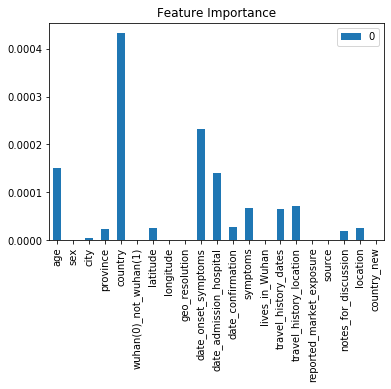

In [943]:
# Implementação. Use mais blocos se achar que ficará mais organizado.
# Transformar idade e tarifa em categorias
#d = [X_train, X_test]
#for dataset in d:
#    dataset['Age'] = dataset['Age'].astype(int)
#    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
#    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
#    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
#    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
#    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
#    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
#    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
#    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

#d = [X_train, X_test]
#for dataset in d:
#    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
#    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
#    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
#    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
#    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
#    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
#    dataset['Fare'] = dataset['Fare'].astype(int)

# COVID
lasso=Lasso(alpha=0.001)
lasso.fit(data_covid, target_covid)
pd.DataFrame(abs(lasso.coef_), index=data_covid.columns).plot(kind='bar', title='Feature Importance')

In [944]:
# COVID
X_train_2 = X_train.drop(['sex', 'longitude', 'geo_resolution', 'source', 'country_new'], axis=1)
X_test_2 = X_test.drop(['sex', 'longitude', 'geo_resolution', 'source', 'country_new'], axis=1)

In [945]:
# Versão 1
params = {'n_estimators':187, 'min_samples_split':2, 'min_samples_leaf':1, 'max_leaf_nodes':14, 'random_state':randomstate, 'criterion':'gini', 'max_features':'auto', 'class_weight':None}
versoes('RandomForestClassifier', 'versão 1', X_train_2, y_train, X_test_2, y_test, params)

Algoritmo    Versão  Train NMSE  Test NMSE  n_estimators  \
0  RandomForestClassifier  baseline      0.0472    0.10618           187   
1  RandomForestClassifier  versão 1      0.0472    0.10618           187   

   min_samples_split  min_samples_leaf  max_leaf_nodes  random_state  \
0                  2                 1              14            64   
1                  2                 1              14            64   

  criterion max_features class_weight  
0      gini         auto         None  
1      gini         auto         None  


#### 3.4) **(10%)** Tunning - Agora que temos um resultado promissor, vamos tentar melhorar o resultado alterando um ou mais hiper-parametro. Compare os resultados.

In [946]:
# Implementação. Use mais blocos se achar que ficará mais organizado.
params = {'n_estimators':187, 'min_samples_split':2, 'min_samples_leaf':2, 'max_leaf_nodes':14, 'random_state':randomstate, 'criterion':'entropy', 'max_features':'auto', 'class_weight':None}
versoes('RandomForestClassifier', 'tunning 1', X_train_2, y_train, X_test_2, y_test, params)

params = {'n_estimators':187, 'min_samples_split':2, 'min_samples_leaf':2, 'max_leaf_nodes':14, 'random_state':randomstate, 'criterion':'gini', 'max_features':'sqrt', 'class_weight':None}
versoes('RandomForestClassifier', 'tunning 2', X_train_2, y_train, X_test_2, y_test, params)

params = {'n_estimators':187, 'min_samples_split':2, 'min_samples_leaf':2, 'max_leaf_nodes':14, 'random_state':randomstate, 'criterion':'gini', 'max_features':'auto', 'class_weight':'balanced'}
versoes('RandomForestClassifier', 'tunning 3', X_train_2, y_train, X_test_2, y_test, params)

params = {'n_estimators':187, 'min_samples_split':2, 'min_samples_leaf':2, 'max_leaf_nodes':14, 'random_state':randomstate, 'criterion':'entropy', 'max_features':'sqrt', 'class_weight':None}
versoes('RandomForestClassifier', 'tunning 4', X_train_2, y_train, X_test_2, y_test, params)

params = {'n_estimators':187, 'min_samples_split':2, 'min_samples_leaf':2, 'max_leaf_nodes':14, 'random_state':randomstate, 'criterion':'entropy', 'max_features':'auto', 'class_weight':'balanced'}
versoes('RandomForestClassifier', 'tunning 5', X_train_2, y_train, X_test_2, y_test, params)

params = {'n_estimators':187, 'min_samples_split':2, 'min_samples_leaf':2, 'max_leaf_nodes':14, 'random_state':randomstate, 'criterion':'gini', 'max_features':'sqrt', 'class_weight':'balanced'}
versoes('RandomForestClassifier', 'tunning 6', X_train_2, y_train, X_test_2, y_test, params)

params = {'n_estimators':187, 'min_samples_split':2, 'min_samples_leaf':2, 'max_leaf_nodes':14, 'random_state':randomstate, 'criterion':'entropy', 'max_features':'sqrt', 'class_weight':'balanced'}
versoes('RandomForestClassifier', 'tunning 7', X_train_2, y_train, X_test_2, y_test, params)

params = {'n_estimators':100, 'min_samples_split':2, 'min_samples_leaf':1, 'max_leaf_nodes':None, 'random_state':randomstate, 'criterion':'gini', 'max_features':'auto', 'class_weight':None}
versoes('RandomForestClassifier', 'tunning 8 - default', X_train_2, y_train, X_test_2, y_test, params)

Algoritmo     Versão  Train NMSE  Test NMSE  n_estimators  \
0  RandomForestClassifier   baseline     0.04720    0.10618           187   
1  RandomForestClassifier   versão 1     0.04720    0.10618           187   
2  RandomForestClassifier  tunning 1     0.10619    0.10618           187   

   min_samples_split  min_samples_leaf  max_leaf_nodes  random_state  \
0                  2                 1              14            64   
1                  2                 1              14            64   
2                  2                 2              14            64   

  criterion max_features class_weight  
0      gini         auto         None  
1      gini         auto         None  
2   entropy         auto         None  
                Algoritmo     Versão  Train NMSE  Test NMSE  n_estimators  \
0  RandomForestClassifier   baseline     0.04720    0.10618           187   
1  RandomForestClassifier   versão 1     0.04720    0.10618           187   
2  RandomForestClassifier  

#### 3.5) Qual método escolhido?

Decision Tree

#### 3.6) **(10%)** Baseline - Implemente seu classificador da forma mais simples possível para esse ser seu baseline

In [947]:
# Carregando os arquivos trabalhados no código "prepara titanic" adaptado a partir de https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8
#X_train = pd.read_csv("X_train.csv")
#y_train = pd.read_csv("y_train.csv")
#X_test = pd.read_csv("X_test.csv")

#print('samples', X_train.shape)
#print('labels', y_train.shape)

In [948]:
# Implementação. Use mais blocos se achar que ficará mais organizado.
baseline('DecisionTreeClassifier', X_train, y_train, X_test, y_test, randomstate)


Algoritmo               Versão  Train NMSE  Test NMSE  \
0   RandomForestClassifier             baseline     0.04720    0.10618   
1   RandomForestClassifier             versão 1     0.04720    0.10618   
2   RandomForestClassifier            tunning 1     0.10619    0.10618   
3   RandomForestClassifier            tunning 2     0.10619    0.10618   
4   RandomForestClassifier            tunning 3     0.10619    0.14157   
5   RandomForestClassifier            tunning 4     0.10619    0.10618   
6   RandomForestClassifier            tunning 5     0.10619    0.14157   
7   RandomForestClassifier            tunning 6     0.10619    0.14157   
8   RandomForestClassifier            tunning 7     0.10619    0.14157   
9   RandomForestClassifier  tunning 8 - default     0.01180    0.10618   
10  DecisionTreeClassifier             baseline     0.10619    0.10618   

   n_estimators  min_samples_split  min_samples_leaf  max_leaf_nodes  \
0           187                  2                 1    

#### 3.7) **(20%)** Versão 1 - O que podemos fazer para melhorar nosso baseline? Aplique técnicas como redução de dimensionalidade, normalização ou outras. Compare os resultados.

In [949]:
# Implementação. Use mais blocos se achar que ficará mais organizado.
# Transformar idade e tarifa em categorias
#d = [X_train, X_test]
#for dataset in d:
#    dataset['Age'] = dataset['Age'].astype(int)
#    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
#    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
#    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
#    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
#    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
#    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
#    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
#    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

#d = [X_train, X_test]
#for dataset in d:
#    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
#    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
#    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
#    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
#    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
#    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
#    dataset['Fare'] = dataset['Fare'].astype(int)

In [950]:
# Versão 1
params = {'criterion':'gini', 'min_samples_split':64, 'min_samples_leaf':4, 'max_features':None, 'max_leaf_nodes':11, 'random_state':randomstate, 'criterion':'gini', 'max_features':'auto', 'class_weight':None}
versoes('DecisionTreeClassifier', 'versão 1', X_train_2, y_train, X_test_2, y_test, params)

Algoritmo               Versão  Train NMSE  Test NMSE  \
0   RandomForestClassifier             baseline     0.04720    0.10618   
1   RandomForestClassifier             versão 1     0.04720    0.10618   
2   RandomForestClassifier            tunning 1     0.10619    0.10618   
3   RandomForestClassifier            tunning 2     0.10619    0.10618   
4   RandomForestClassifier            tunning 3     0.10619    0.14157   
5   RandomForestClassifier            tunning 4     0.10619    0.10618   
6   RandomForestClassifier            tunning 5     0.10619    0.14157   
7   RandomForestClassifier            tunning 6     0.10619    0.14157   
8   RandomForestClassifier            tunning 7     0.10619    0.14157   
9   RandomForestClassifier  tunning 8 - default     0.01180    0.10618   
10  DecisionTreeClassifier             baseline     0.10619    0.10618   
11  DecisionTreeClassifier             versão 1     0.10619    0.10618   

   n_estimators  min_samples_split  min_samples_leaf  

#### 3.8) **(10%)** Tunning - Agora que temos um resultado promissor, vamos tentar melhorar o resultado alterando um ou mais hiper-parametro. Compare os resultados.

In [951]:
# Implementação. Use mais blocos se achar que ficará mais organizado.
params = {'criterion':'gini', 'min_samples_split':64, 'min_samples_leaf':4, 'max_features':None, 'max_leaf_nodes':11, 'random_state':randomstate, 'criterion':'entropy', 'max_features':'auto', 'class_weight':None}
versoes('DecisionTreeClassifier', 'tunning 1', X_train_2, y_train, X_test_2, y_test, params)

params = {'criterion':'gini', 'min_samples_split':64, 'min_samples_leaf':4, 'max_features':None, 'max_leaf_nodes':11, 'random_state':randomstate, 'criterion':'gini', 'max_features':'sqrt', 'class_weight':None}
versoes('DecisionTreeClassifier', 'tunning 2', X_train_2, y_train, X_test_2, y_test, params)

params = {'criterion':'gini', 'min_samples_split':64, 'min_samples_leaf':4, 'max_features':None, 'max_leaf_nodes':11, 'random_state':randomstate, 'criterion':'gini', 'max_features':'auto', 'class_weight':'balanced'}
versoes('DecisionTreeClassifier', 'tunning 3', X_train_2, y_train, X_test_2, y_test, params)

params = {'criterion':'gini', 'min_samples_split':64, 'min_samples_leaf':4, 'max_features':None, 'max_leaf_nodes':11, 'random_state':randomstate, 'criterion':'entropy', 'max_features':'sqrt', 'class_weight':None}
versoes('DecisionTreeClassifier', 'tunning 4', X_train_2, y_train, X_test_2, y_test, params)

params = {'criterion':'gini', 'min_samples_split':64, 'min_samples_leaf':4, 'max_features':None, 'max_leaf_nodes':11, 'random_state':randomstate, 'criterion':'entropy', 'max_features':'auto', 'class_weight':'balanced'}
versoes('DecisionTreeClassifier', 'tunning 5', X_train_2, y_train, X_test_2, y_test, params)

params = {'criterion':'gini', 'min_samples_split':64, 'min_samples_leaf':4, 'max_features':None, 'max_leaf_nodes':11, 'random_state':randomstate, 'criterion':'gini', 'max_features':'sqrt', 'class_weight':'balanced'}
versoes('DecisionTreeClassifier', 'tunning 6', X_train_2, y_train, X_test_2, y_test, params)

params = {'criterion':'gini', 'min_samples_split':64, 'min_samples_leaf':4, 'max_features':None, 'max_leaf_nodes':11, 'random_state':randomstate, 'criterion':'entropy', 'max_features':'sqrt', 'class_weight':'balanced'}
versoes('DecisionTreeClassifier', 'tunning 7', X_train_2, y_train, X_test_2, y_test, params)

params = {'criterion':'gini', 'min_samples_split':2, 'min_samples_leaf':1, 'max_features':None, 'max_leaf_nodes':None, 'random_state':randomstate, 'criterion':'gini', 'max_features':None, 'class_weight':None}
versoes('DecisionTreeClassifier', 'tunning 8 - default', X_train_2, y_train, X_test_2, y_test, params)

          11.0   

    random_state criterion max_features class_weight  
0             64      gini         auto         None  
1             64      gini         auto         None  
2             64   entropy         auto         None  
3             64      gini         sqrt         None  
4             64      gini         auto     balanced  
5             64   entropy         sqrt         None  
6             64   entropy         auto     balanced  
7             64      gini         sqrt     balanced  
8             64   entropy         sqrt     balanced  
9             64      gini         auto         None  
10            64      gini         auto         None  
11            64      gini         auto         None  
12            64   entropy         auto         None  
13            64      gini         sqrt         None  
14            64      gini         auto     balanced  
                 Algoritmo               Versão  Train NMSE  Test NMSE  \
0   RandomForestClassifier 

### 5) **(10%)** Conclusões

*Compare seus resultados. Imaginando que sua solução fosse para produção, qual deles você escolheria? Por que? Quais os riscos você enxerga? O que recomendaria de próximos passos para melhorar os resultados?*

In [952]:
pd.DataFrame(resultados)


,Algoritmo,Versão,Train NMSE,Test NMSE,n_estimators,min_samples_split,min_samples_leaf,max_leaf_nodes,random_state,criterion,max_features,class_weight
0,RandomForestClassifier,baseline,0.04720,0.10618,187,2,1,14.0,64,gini,auto,None
1,RandomForestClassifier,versão 1,0.04720,0.10618,187,2,1,14.0,64,gini,auto,None
2,RandomForestClassifier,tunning 1,0.10619,0.10618,187,2,2,14.0,64,entropy,auto,None
3,RandomForestClassifier,tunning 2,0.10619,0.10618,187,2,2,14.0,64,gini,sqrt,None
4,RandomForestClassifier,tunning 3,0.10619,0.14157,187,2,2,14.0,64,gini,auto,balanced
5,RandomForestClassifier,tunning 4,0.10619,0.10618,187,2,2,14.0,64,entropy,sqrt,None
6,RandomForestClassifier,tunning 5,0.10619,0.14157,187,2,2,14.0,64,entropy,auto,balanced
7,RandomForestClassifier,tunning 6,0.10619,0.14157,187,2,2,14.0,64,gini,sqrt,balanced
8,RandomForestClassifier,tunning 7,0.10619,0.14157,187,2,2,14.0,64,entropy,sqrt,balanced
9,RandomForestClassifier,tunning 8 - default,0.01180,0.10618,100,2,1,NaN,64,gini,auto,None
